# Numerai Round 252

## Parameter Vector Model

Goals this round:
- Train the model with correlation, not average distance from target
- Use validation data before submission

Train the model to find a golden parameter vector of equal dimensionality, plus one extra dimension for weight. 

To predict the target, calculate the angle (cosine distance), and the relative magnitude between teh parameter vector. Let the weight

### 1. Prepare Notebook

#### Column descriptions
*   id: a randomized id that corresponds to a stock 
*   era: a period of time
*   data_type: either `train`, `validation`, `test`, or `live` 
*   feature_*: abstract financial features of the stock 
*   target: abstract measure of stock performance

##### Install Dependencies and Import Packages

In [1]:
# !pip install pandas sklearn numerapi
# !pip install tqdm npm ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# !pip install ipympl
# %matplotlib widget
# !jupyter labextension install jupyter-matplotlib
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-matplotlib

# import dependencies
import pandas as pd
from scipy.spatial import distance
from os import path
from tqdm.notebook import tqdm, trange
import numpy
import math
import random as rand
import numerapi
import time
import sys
import matplotlib.pyplot as plt
from IPython.display import clear_output

##### General Functions

In [2]:
def savemodel():
    global golden_weight
    global golden_parameter
    w = numpy.array(golden_weight, dtype=numpy.float32)
    p = numpy.array(golden_parameter, dtype=numpy.float32)
    model = numpy.append(w, p)
    numpy.savetxt('model.csv', model, delimiter=',')
    print("Model saved!")
    
def loadmodel():
    global golden_weight
    global golden_parameter
    global weight
    global parameter
    
    if path.exists('model.csv'):
        model_data = numpy.loadtxt('model.csv')
        golden_weight = model_data[0]
        golden_parameter = model_data[1:]
    else:
        golden_parameter = numpy.random.rand(num_features, 1)
        golden_weight = numpy.random.random()
    
    weight = golden_weight
    parameter = golden_parameter
    model_data = None
    
def predict(stock, parameter, w):
    dist_stock = math.sqrt(sum(pow(element, 2) for element in stock))
    dist_param = math.sqrt(sum(pow(element, 2) for element in parameter))
    if dist_stock == 0 or dist_param == 0:
        dist = 0
    else:
        dist = min(dist_stock / dist_param, dist_param / dist_stock)
    angle = distance.cosine(stock, parameter)
    return (w * dist) + ((1 - w) * angle)

def updatedelta(dt):
    global delta_weight
    global delta_param
    delta = dt * math.pow(-1,rand.randint(1,2)) # step size
    delta_weight = delta * numpy.random.random()
    delta_param = delta * numpy.random.rand(num_features, 1)
    
def updateparams(p, w):
    global weight
    weight = clamp(w + delta_weight, 0, 1)
    global parameter
    parameter = numpy.add(numpy.ndarray.flatten(p), numpy.ndarray.flatten(delta_param))
    parameter = clamparray(parameter, 0, 1)
    
def clamp(my_value, min_value, max_value):
    return max(min(my_value, max_value), min_value)

def clamparray(array, min_val, max_val):
    for i in range(len(array)):
        array[i] = clamp(array[i], min_val, max_val)
    return array

##### Download Latest Data

In [3]:
# download the latest training dataset (takes around 30s)
training_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz")
# download the latest tournament dataset (takes around 30s)
tournament_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz")
tournament_data.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,...,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,...,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,...,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,...,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,...,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,0.75


### 2. Train the Model

In [4]:
# find only the feature columns
feature_cols = training_data.columns[training_data.columns.str.startswith('feature')]
training_features = training_data[feature_cols]
num_features = len(training_features.columns)

# load the model if we have a saved csv
loadmodel()

# parameters
delta_size = 0.05 # 1 = random jumping, 0 = same every time, small = tiny steps
skip_rows = 10 # 1 = use all data, >1 = skip this many rows at a time
num_improvements = 0 # number of improvements this run
updatedelta(delta_size) # initialize the delta parameter, will still start with golden_parameter
best_correlation = float('-inf') # always win on first try. if we are loading, we are using golden, so doesnt hurt to still save
running = True
search_mode = "last"; # "last" = update from last parameter, "best" = update from golden parameter

# keep looping to optimize the parameter vector and weight
while running:
    try:
        # loop through each row in the training set, only with a randomly selected subset
        selected_features = training_features.iloc[::skip_rows, :]
        train_predictions = []
        train_targets = []
        for index, stock in tqdm(selected_features.iterrows(), total=len(selected_features.index)):
            pred = training_data.target.values[index]
            targ = predict(stock.values, parameter, weight)
            train_predictions.append(pred)
            train_targets.append(targ)
        # calculate correlation and determine if its a new high
        clear_output(wait=True)
        this_correlation = numpy.corrcoef(train_targets, train_predictions)[0, 1]
        if this_correlation > best_correlation:
            golden_parameter = parameter
            golden_weight = weight
            best_correlation = this_correlation
            savemodel()
            num_improvements += 1
            print("New best correlation is", round(best_correlation,4))
        else:
            updatedelta(delta_size) # only change our direction if we were not successful this round
            print("Correlation =", round(this_correlation, 4), "Current best =", round(best_correlation,4), "Num. improvements this round =", num_improvements, "No improvement, trying again...")
        # update the parameters at the end of every round
        if search_mode == "last": updateparams(golden_parameter, golden_weight)
        if search_mode == "best": updateparams(parameter, weight)
    except KeyboardInterrupt:
        running = False

Correlation = nan Current best = 0.0174 Num. improvements this round = 2 No improvement, trying again...


  0%|          | 0/50181 [00:00<?, ?it/s]

### 3. Validate Model

In [ ]:
try: lin_preds
except NameError: lin_preds = None

if lin_preds is None:
    import sklearn.linear_model
    model = sklearn.linear_model.LinearRegression()
    model.fit(training_features, training_data.target)
    lin_preds = model.predict(training_features)

these_targets = training_data.target.values
rand_preds = numpy.ndarray.flatten(numpy.random.rand(these_targets.shape[0], 1))
plt.rcParams['figure.figsize'] = [20, 5]
plt.subplot(1,3,1)
plt.hist(numpy.absolute(numpy.subtract(these_targets, rand_preds)))
plt.title('Error Distribution Random Guess')
plt.subplot(1,3,2)
plt.hist(numpy.absolute(numpy.subtract(these_targets, lin_preds)))
plt.title('Error Distribution Linear Regression')
plt.subplot(1,3,3)
plt.hist(numpy.absolute(numpy.subtract(train_targets, train_predictions)))
plt.title('Error Distribution Latest Model')
plt.show()

  0%|          | 0/501808 [00:00<?, ?it/s]

  0%|          | 0/1660502 [00:00<?, ?it/s]

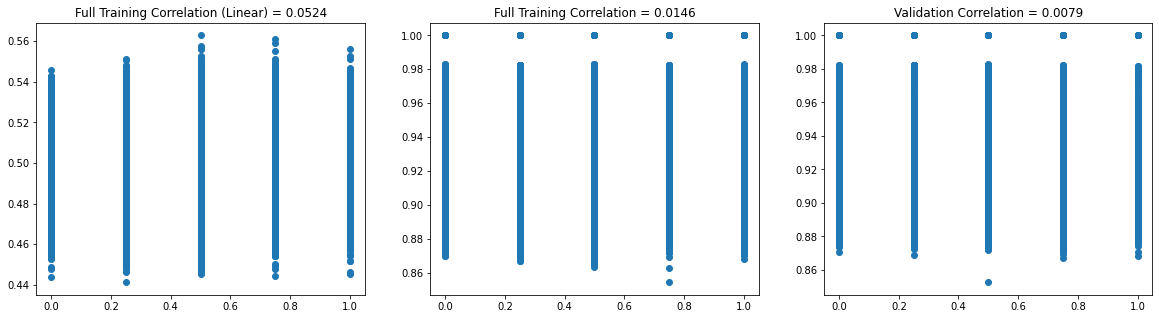

In [7]:
# select the feature columns from the tournament data
feature_cols = tournament_data.columns[tournament_data.columns.str.startswith('feature')]
training_features = training_data[feature_cols]
live_features = tournament_data[feature_cols]

# predict the target on the live features
loadmodel()

training_predictions = []
training_targets = []
for index, stock in tqdm(training_features.iterrows(), total = len(training_features.index)):
    this_target = training_data.target.values[index]
    if math.isnan(this_target):
        continue
    training_predictions.append(predict(stock.values, golden_parameter, golden_weight))
    training_targets.append(this_target)
    
validation_predictions = []
validation_targets = []
for index, stock in tqdm(live_features.iterrows(), total = len(live_features.index)):
    this_target = tournament_data.target.values[index]
    if math.isnan(this_target):
        continue
    validation_predictions.append(predict(stock.values, golden_parameter, golden_weight))
    validation_targets.append(this_target)
    
# calculate linear model predictions as benchmark
try: lin_preds
except NameError: lin_preds = None

if lin_preds is None:
    import sklearn.linear_model
    model = sklearn.linear_model.LinearRegression()
    model.fit(training_features, training_data.target)
    lin_preds = model.predict(training_features)

# plot predictions vs targets, and calculate correlation
plt.rcParams['figure.figsize'] = [20, 5]
plt.subplot(1,3,1)
plt.scatter(training_data.target.values, lin_preds)
corr = round(numpy.corrcoef(training_data.target.values, lin_preds)[0, 1], 4)
plt.title("Full Training Correlation (Linear) = " + str(corr))
plt.subplot(1,3,2)
plt.scatter(training_targets, training_predictions)
corr = round(numpy.corrcoef(training_targets, training_predictions)[0, 1], 4)
plt.title("Full Training Correlation = " + str(corr))
plt.subplot(1,3,3)
plt.scatter(validation_targets, validation_predictions)
corr = round(numpy.corrcoef(validation_targets, validation_predictions)[0, 1], 4)
plt.title("Validation Correlation = " + str(corr))
plt.show()

### 4. Generate Predictions

In [8]:
# select the feature columns from the tournament data
feature_cols = tournament_data.columns[tournament_data.columns.str.startswith('feature')]
live_features = tournament_data[feature_cols]

# predict the target on the live features
loadmodel()
predictions = numpy.zeros(len(live_features.index))
for index, stock in tqdm(live_features.iterrows(), total = len(predictions)):
    predictions[index] = predict(stock.values, golden_parameter, golden_weight)

# predictions must have an `id` column and a `prediction_kazutsugi` column
predictions_df = tournament_data["id"].to_frame()
predictions_df["prediction_kazutsugi"] = predictions
predictions_df.head()

  0%|          | 0/1660502 [00:00<?, ?it/s]

,id,prediction_kazutsugi
0,n0003aa52cab36c2,0.929426
1,n000920ed083903f,0.895990
2,n0038e640522c4a6,0.934362
3,n004ac94a87dc54b,0.932116
4,n0052fe97ea0c05f,0.950093


### 5. Submit Predictions

In [ ]:
# Get API keys and model_id from https://numer.ai/submit
public_id = "JQSPCE2MKNH2BDULWMLU7SERQF4YDACE"
secret_key = "BLZJU3NECY3ZOZ6TXBY5XR7LY2VC3DFH4UVXF3VVWTE2P5NS7EZL73UUOMOH5BZH"
model_id = "777a91f4-d61e-43dc-8b96-1ec25afd1da4"
napi = numerapi.NumerAPI(public_id=public_id, secret_key=secret_key)
predictions_df.to_csv("predictions.csv", index=False)
submission_id = napi.upload_predictions("predictions.csv", model_id=model_id)

2021-02-21 11:22:57,992 INFO numerapi.base_api: uploading predictions...


##### Done!